# Identify Multiple Peaks on Ligo Maps

In this notebook I want to identify double or more peaks on the ligo maps. For this, I use a gaussian mixture model.

In [1]:
from astropy.io import fits
from astropy.utils.data import download_file
from astropy.wcs import WCS
import healpy as hp
# from reproject import reproject_from_healpix
import numpy as np

In [2]:
# !pip install healpy

In [3]:
# downaload a ligo map
# url = 'https://dcc.ligo.org/public/0146/G1701985/001/bayestar.fits.gz'  
url = 'https://gracedb.ligo.org/apiweb/superevents/S200115j/files/bayestar.fits.gz'
filename = download_file(url, cache=True, show_progress=False)  
_, healpix_hdu = fits.open(filename,density = False)
prob = hp.read_map(healpix_hdu, verbose=False) 

In [70]:
Nsize    = prob.size
i = np.flipud(np.argsort(prob))
sorted_credible_levels = np.cumsum(prob[i])
credible_levels = np.empty_like(sorted_credible_levels)
credible_levels[i] = sorted_credible_levels
hpx_90percent, = np.where(credible_levels <= 0.9)
prob_90percent = np.where(credible_levels <= 0.9, prob, 0.)

In [71]:
sum_prob = np.sum(prob_90percent)
indices  = np.arange(Nsize, dtype=int)

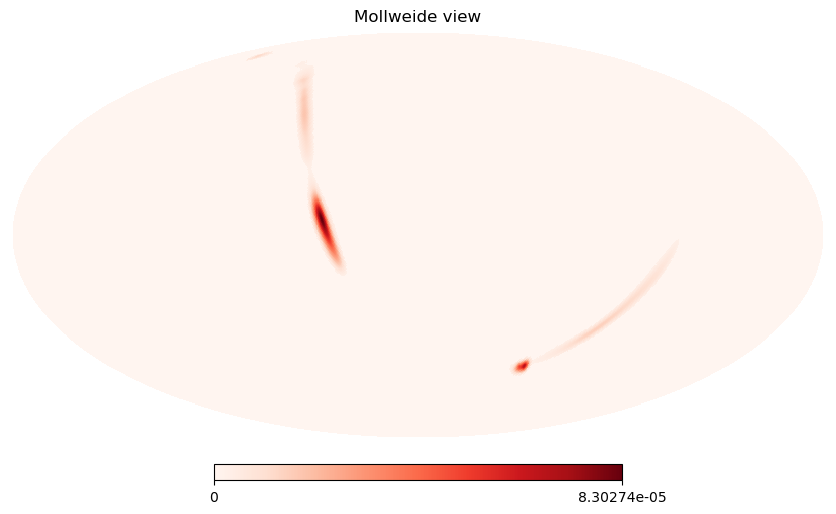

In [72]:
hp.mollview(prob_90percent, cmap='Reds')

In [73]:
# GMM does not have weights!
# samples 1000*Nsize points from the probabilities 
# produce a point density that resembles the probability map
indices_rnd = np.random.choice(indices, size=int(Nsize), replace=True, p=prob_90percent/sum_prob)

## Gaussian Mixture Model On Healpix Pixel

In [74]:
from sklearn import mixture
import healpy as hp

X = indices_rnd[:,np.newaxis]
gmm = mixture.GaussianMixture(n_components=4, covariance_type="diag").fit(X)

In [75]:
import matplotlib.pyplot as plt

def gaussian(x,mean,std):
    arg = (x-mean)/std
    return np.exp(-arg**2/2.)/np.sqrt(2*np.pi*std**2)

def plot_gaussian(xvec, mean, s, w=1):
    plt.plot(xvec, w*gaussian(xvec,mean,s))
    
def plot_gmm(gmm,xvec):
    means = np.round(gmm.means_,0).astype(int).flatten()
    stds = np.sqrt(gmm.covariances_).flatten()
    weights = gmm.weights_.flatten()
    for m,s,w in zip(means, stds, weights):
        plot_gaussian(xvec, m, s, w)
        

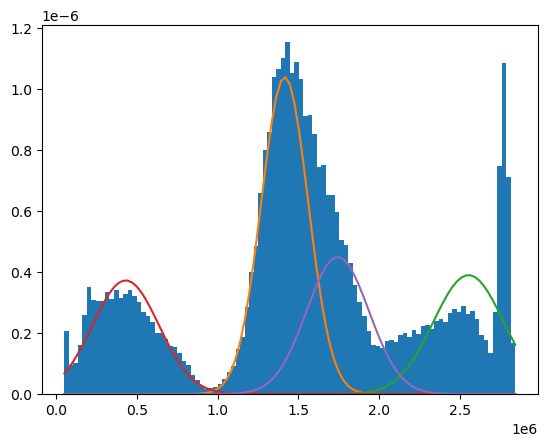

In [76]:
_ = plt.hist(indices_rnd, bins=100, density=True)
plot_gmm(gmm,_[1])

## K-means?

In [77]:
from sklearn.cluster import KMeans

kmeans = KMeans(n_clusters=5, random_state=0)
labels = kmeans.fit_predict(X)

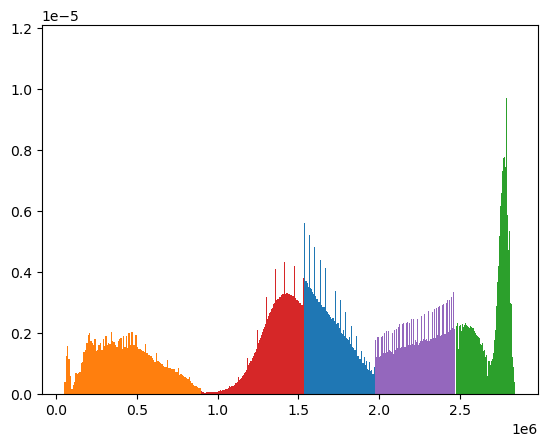

In [78]:
for i in range(5):
    mask = labels == i
    _ = plt.hist(indices_rnd[mask], bins=100, density=True)

## Gaussian Mixture Model on Sky Coordinates

In [99]:
Nside = hp.npix2nside(Nsize)

# convert to sky coordinates
t, phi = hp.pix2ang(Nside,indices_rnd)
dec,ra = np.degrees(90-t),np.degrees(phi)

X = np.vstack([ra,dec]).T

In [100]:
gmm = mixture.GaussianMixture(n_components=5, covariance_type="tied").fit(X)

# predict on the original map
t, phi = hp.pix2ang(Nside,indices)
dec_new,ra_new = np.degrees(90-t),np.degrees(phi)

Xnew = np.vstack([ra_new,dec_new]).T
labels = gmm.predict(Xnew)

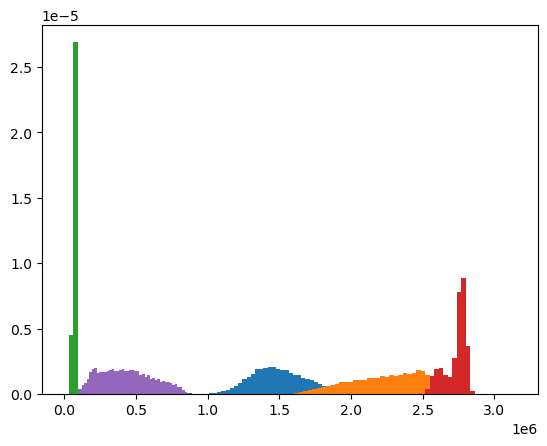

In [101]:
for i in range(5):
    mask = labels == i
    _ = plt.hist(indices[mask], weights=prob_90percent[mask], bins=100, density=True)

I think it worked! Let's plot sky maps

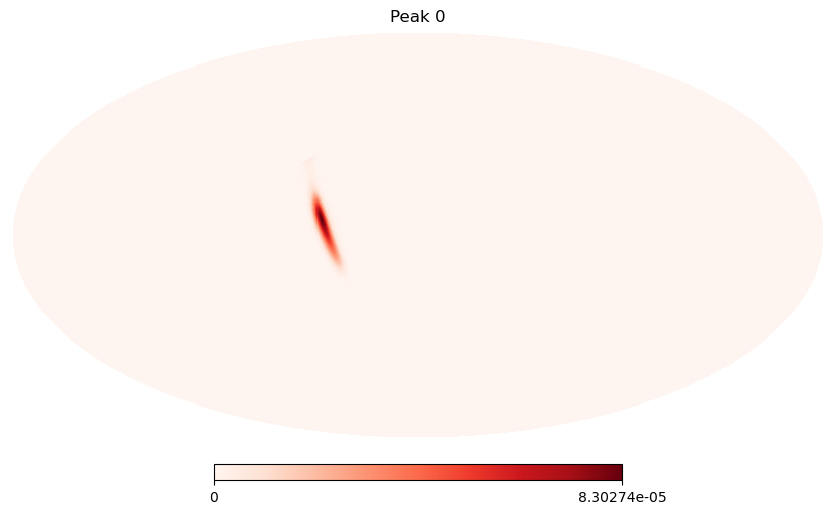

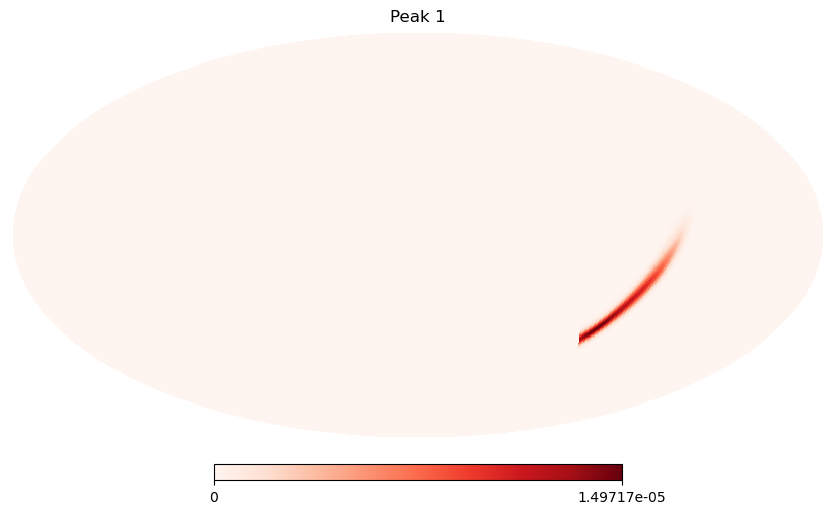

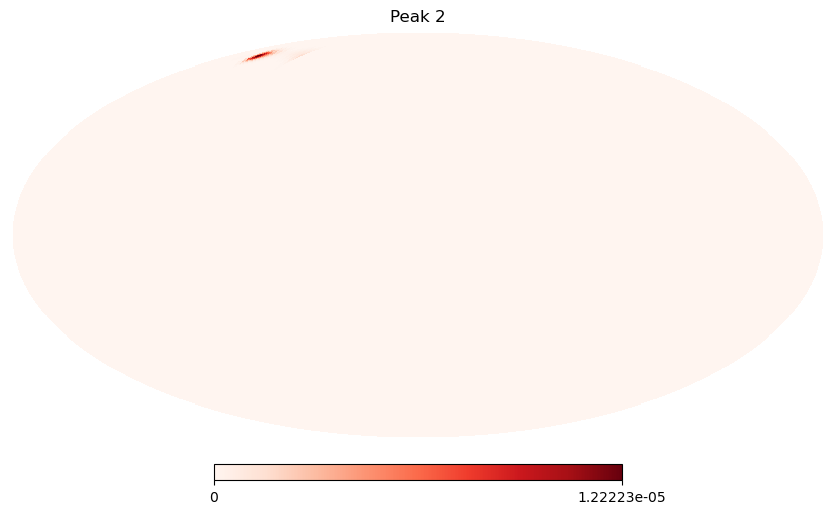

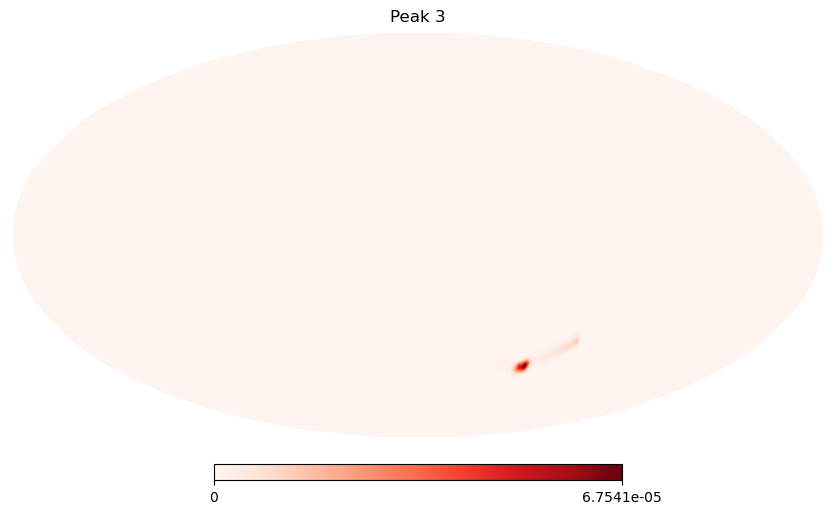

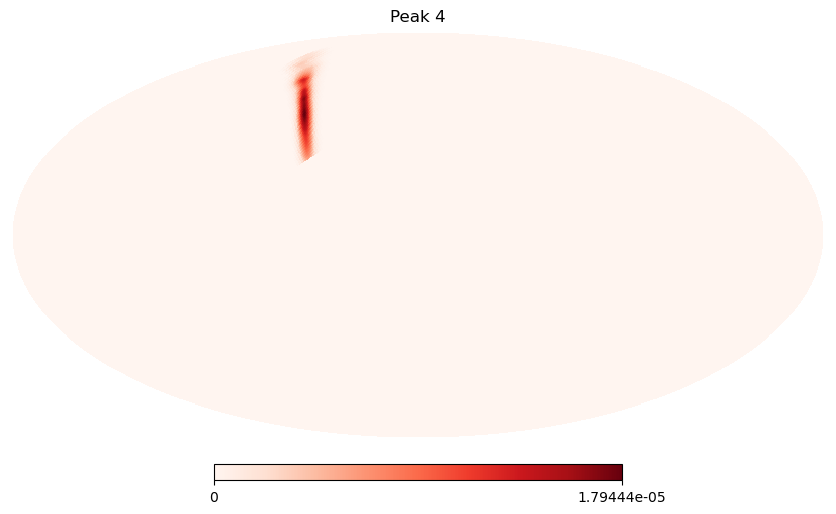

In [102]:
for i in range(np.unique(labels).size):
    mask = labels == i
    hpmap = np.where(mask,prob,0.)
    hp.mollview(hpmap,cmap='Reds')
    plt.title('Peak %i'%i)

# Things to do

1. Find the best number of components
2. Test the GMM Choices and Compare with K-means
3. Find the ellipses in RA/DEC and the angular separation

For the step 3, the ligo sky-map [ellipse](https://lscsoft.docs.ligo.org/ligo.skymap/postprocess/ellipse.html) code gives you the properties of the ellipse for each group.